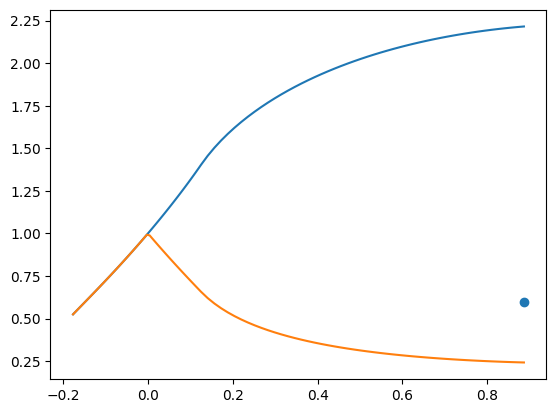

In [112]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import sqlite3 
import json

# Inputs
P1 = 500000 
n = 100

#specInputs = [K1, K2, theta_n, theta_e, %L]
specInputs = [0.5, 0.5, 30, 6, 0.8]

class BellNozzle:
    def __init__(self, defCheck, P1, n, ENGINE, specInputs):
        self.P1 = P1
        self.n = n

        self.engine_Data = self.get_engine_data(ENGINE)

        self.propellant = self.engine_Data["Propellant"]
        self.P0         = self.engine_Data["P0"]
        self.Rt         = self.engine_Data["Rt"]

        self.mass       = self.engine_Data["totalMass"]
        self.time       = self.engine_Data["totalTime"]

        self.t          = self.engine_Data["tree_data"]["Tiempo (s)"]
        self.P_t        = self.engine_Data["tree_data"]["Presi\u00f3n (Pa)"]
        self.G_t        = self.engine_Data["tree_data"]["Flujo M\u00e1sico (kg/s)"]
        self.M_t        = self.engine_Data["tree_data"]["Masa (kg)"]

        if defCheck:
            self.G      = self.engine_Data["meanMassFlow"]
        else:
            self.G      = self.interpolate_mass_flow(self.P1)
        
        self.propellant_Data = self.get_propellant_data()

        self.gamma = self.propellant_Data['gamma']
        self.R = self.propellant_Data['R']
        self.T1 = self.propellant_Data['T_ad']
        self.cChar = self.propellant_Data['cChar']

        self.M2 = np.sqrt((2 / (self.gamma - 1)) * ((self.P1 / self.P0)**((self.gamma - 1)/self.gamma) - 1))
        self.e  = (1/self.M2) * ((2/(self.gamma + 1))*(1 + ((self.gamma - 1)/2) * self.M2**2))**(self.gamma + 1)/(2*(self.gamma - 1))
        self.T2 = self.T1 / (1 + ((self.gamma - 1)/2) * self.M2**2)
        self.V2 = self.M2 * np.sqrt(self.gamma * self.R * self.T2)
        self.R2 = self.Rt * np.sqrt(self.e)
        self.F = self.G * self.V2
        self.F_kg = self.G * self.V2 / 9.80665

        self.K1 = specInputs[0]
        self.K2 = specInputs[1]
        self.theta_n = np.deg2rad(specInputs[2])
        self.theta_e = np.deg2rad(specInputs[3])
        self.percL = specInputs[4]

        thList = np.linspace(-3 * np.pi /4, self.theta_n - np.pi/2, int(self.n/2))
        self.throatIndex = np.argmin(np.abs(thList + np.pi/2))
        self.geo_Throat = np.array([self.f_throat(th) for th in thList])

        self.Nx, self.Ny = self.f_throat(self.theta_n - np.pi/2)
        self.Ex, self.Ey = self.percL * ((np.sqrt(self.e) - 1) * self.Rt) / np.tan(self.theta_n/2), np.sqrt(self.e) * self.Rt
        self.m1, self.m2 = np.tan(self.theta_n), np.tan(self.theta_e)
        self.C1, self.C2 = self.Ny - self.m1 * self.Nx, self.Ey - self.m2 * self.Ex
        self.Qx, self.Qy = (self.C2 - self.C1) / (self.m1 - self.m2), (self.C2 * self.m1 - self.C1 * self.m2) / (self.m1 - self.m2)

        tList = np.linspace(0, 1, int(self.n/2))
        self.geo_Bell = np.array([self.f_bell(t) for t in tList])
        self.geo_Nozzle = np.concatenate((self.geo_Throat, self.geo_Bell))


        self.AR_x = self.geo_Nozzle[:,1]**2 / self.Rt**2

        self.M_x_3 = np.array([
            fsolve(self.f_AR, 1.5, args=(AR,))[0] if i > self.throatIndex else fsolve(self.f_AR, 0.5, args=(AR,))[0]
            for i, AR in enumerate(self.AR_x)
        ])

        self.M_e_2 = np.sqrt((1 + (self.gamma - 1)/2 * self.M2**2) / (self.gamma * self.M2**2 - (self.gamma - 1)/2))
        
        self.M_x_1 = np.array([fsolve(self.f_AR, 0.5, args=(AR,))[0] for AR in self.AR_x])

        

        self.PRatio_1 = self.P_ratio(self.M_x_1)**-1
        self.PRatio_2 = ((1 + (2 * self.gamma)/(self.gamma + 1) * (self.M2**2 - 1)) )**-1
        self.PRatio_3 = self.P_ratio(self.M_x_3)**-1

    





    
    def f_throat(self, th):
        if  -3 * np.pi /4 <= th < - np.pi/2:
            x = self.K1 * self.Rt * np.cos(th)
            y = self.K1 * self.Rt * np.sin(th) + self.K1 * self.Rt + self.Rt
        elif - np.pi/2 <= th <= self.theta_n - np.pi/2:
            x = self.K2 * self.Rt * np.cos(th)
            y = self.K2 * self.Rt * np.sin(th) + self.K2 * self.Rt + self.Rt
        return x,y
    
    def f_bell(self, t):
        x = (1 - t)**2 * self.Nx + 2 * (1 - t) * t * self.Qx + t**2 * self.Ex
        y = (1 - t)**2 * self.Ny + 2 * (1 - t) * t * self.Qy + t**2 * self.Ey
        return x,y
    
    def f_AR(self, M, AR):
        return (1 / M) * ((2/(self.gamma + 1)) * (1 + ((self.gamma - 1)/2) * M**2))**((self.gamma + 1)/(2*(self.gamma - 1))) - AR
    
    def P_ratio(self, M):
        return (1 + ((self.gamma - 1)/2) * M**2)**(self.gamma/(self.gamma - 1))

    def get_engine_data(self, ENG):
        # Ruta al archivo JSON
        file_path = 'workingDirectory\\Engines\\' + ENG + '.json'
        # Abrir y cargar el archivo JSON
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data

    def get_propellant_data(self):
        conn = sqlite3.connect('database.db')
        cursor = conn.cursor()
        query = "SELECT gamma, R, T_ad, cChar FROM propelente WHERE Propelente = ?"
        cursor.execute(query, (self.propellant,))
        resultado = cursor.fetchone()
        conn.close()
        if resultado:
            props = {
                "gamma":    float(resultado[0]),
                "R":        float(resultado[1]),
                "T_ad":     float(resultado[2]),
                "cChar":    float(resultado[3])
            }
            return props
        else:
            # Retornar None si no se encuentra el propelente
            return None

    def interpolate_mass_flow(self, P1):
        interpolate_time = interp1d(self.P_t, self.t, bounds_error=False, fill_value="extrapolate")
        time_value = interpolate_time(P1)
        interpolate_mass_flow = interp1d(self.t, self.G_t, bounds_error=False, fill_value="extrapolate")
        G_value = interpolate_mass_flow(time_value)
        return G_value
    
    def geom_plot(self):
        plt.plot(bn.geo_Nozzle[:,0], bn.geo_Nozzle[:,1])
        plt.axis('equal')
    
    def mach_plot(self):
        plt.plot(self.geo_Nozzle[:,0], self.M_x_3)
        plt.scatter(self.geo_Nozzle[-1,0], self.M_e_2)
        plt.plot(self.geo_Nozzle[:,0], self.M_x_1)

    def pres_plot(self):
        plt.plot(self.geo_Nozzle[:,0], self.PRatio_1)
        plt.plot(self.geo_Nozzle[:,0], self.PRatio_3)
        plt.scatter(self.geo_Nozzle[-1,0], self.PRatio_2)

bn = BellNozzle(False, P1, 100, 'Tubular-KNSU-2', specInputs)
bn.mach_plot()


In [ ]:


P2  =   P3
v2  =   np.sqrt(((2*gamma)/(gamma-1))*R*T1*(1-(P2/P1)**((gamma-1)/gamma)))
G   =   regressionRate(P1,coefs[0],coefs[1])*Aref*rho
corr_factor = 0.5*(1+math.cos(np.radians(6)))
T   =   (G*v2/9.81)*corr_factor
At  =   G/(P1*gamma*np.sqrt((2/(gamma+1))**((gamma+1)/(gamma-1))/(gamma*R*T1)))
M2  =   np.sqrt((2/(gamma-1))*((P1/P2)**((gamma-1)/gamma)-1))
M2_BN5 = M2
e   =   (1/M2)*((2/(gamma+1))*(1+((gamma-1)/2)*M2**2))**((gamma+1)/(2*(gamma-1)))
A2  =   At*e
Dt  =   2*np.sqrt(At/np.pi)
D2  =   2*np.sqrt(A2/np.pi)
D2_BN5 = D2
#Cf  =   np.sqrt(((2*gamma**2)/(gamma-1))*((2/(gamma+1))**((gamma+1)/(gamma-1)))*((P1/P3)**((gamma-1)/gamma)-1))#(T*9.81)/(At*P1)
Cf  =   (T*9.81)/(At*P1)
cStar = P1*At/G
Isp = cStar*Cf/9.81

T2 = T1/(1+((gamma-1)/2)*M2**2)
Tt = T1/((gamma+1)/2)
Pr = P1/((gamma+1)/2)**(gamma/(gamma-1))
P2 = P1/(1+((gamma-1)/2)*M2**2)**(gamma/(gamma-1))



def BELL_APROX(Dt,D2):

    R2 = D2/2
    Rt = Dt/2 

    Rchamber = 1.25*R2

    theta_t = 30
    theta_e = 6
    percent_CLN = 0.8


    theta_0 = 3*np.pi/2
    theta_t = np.radians(theta_t)
    theta_e = np.radians(theta_e)

    mt = math.tan(theta_t)
    me = math.tan(theta_e)

    aRatio = R2**2/Rt**2
    lCone = (R2-Rt)/math.tan(np.radians(15))        # 15 Degree as standard
    lBell = percent_CLN*lCone

    leftRt = 1.5*Rt
    rightRt = 0.4*Rt

    cLCircle = [0,2.5*Rt]
    cRCircle = [0,1.4*Rt]


    def leftCircle(theta):
        return [cLCircle[0] + leftRt*math.cos(theta), cLCircle[1] + leftRt*math.sin(theta),]

    def rightCircle(theta):
        return [cRCircle[0] + rightRt*math.cos(theta), cRCircle[1] + rightRt*math.sin(theta),]

    pE = [lBell,R2]
    pI = rightCircle(theta_t + theta_0)

    n1 = pI[1] - mt*pI[0]
    n2 = pE[1] - me*pE[0]

    pQ = [(n2-n1)/(mt-me), mt*((n2-n1)/(mt-me))+n1]

    def bellFunc(t):
        return [((1-t)**2)*pI[0] + 2*(1-t)*t*pQ[0] + (t**2)*pE[0], ((1-t)**2)*pI[1] + 2*(1-t)*t*pQ[1] + (t**2)*pE[1]]


    leftCirclePoints = np.array([leftCircle(i) for i in np.arange(np.pi,theta_0,0.01)])
    rightCirclePoints = np.array([rightCircle(i) for i in np.arange(theta_0,theta_0+theta_t,0.001)])
    bellPoints = np.array([bellFunc(i) for i in np.arange(0,1,0.001)])

    return pd.DataFrame(np.concatenate((rightCirclePoints, bellPoints), axis=0),columns=["X","Y"]).to_csv('ToberasCSV\\bellAprox.csv',index=False),rightCirclePoints,bellPoints

In [3]:
F = 10*9.81
A2 = np.pi
P2 = 101325
gamma = 1.4

M2 = np.sqrt(F / (A2*P2*gamma))
M2

0.014836697540683163